Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No windowing system present. Using surfaceless platform
No config found!
No config found!


Available devices:
✅ (default) | NVIDIA GeForce GTX 1080 Ti | DiscreteGPU | Vulkan | 555.42.06
❗ | llvmpipe (LLVM 15.0.7, 256 bits) | CPU | Vulkan | Mesa 23.2.1-1ubuntu3.1~22.04.2 (LLVM 15.0.7)
❗ | NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2 | Unknown | OpenGL | 
Listening for updated Lorenz coordinates...


RFBOutputContext()

/home/edwin/edwin_improv/fpl/lib/python3.10/site-packages/fastplotlib/graphics/_features/_base.py:21: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


Automatically created module for IPython interactive environment


JupyterWgpuCanvas(css_height='560px', css_width='700px')
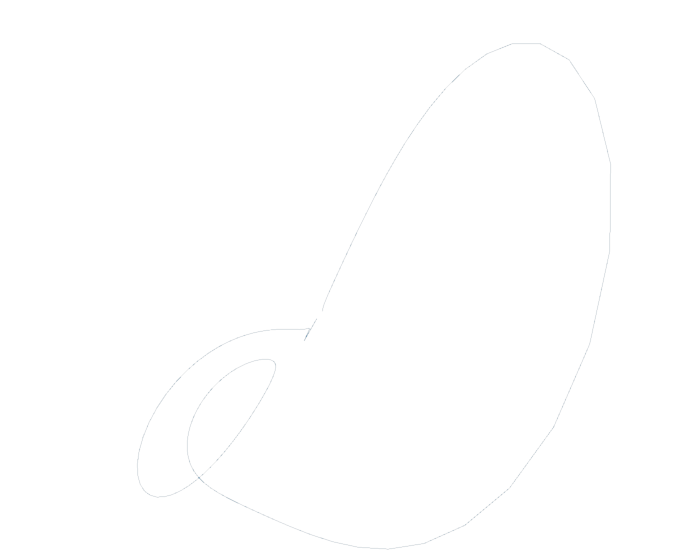

In [1]:
import zmq
import numpy as np
import fastplotlib as fpl
import time  # Import time module

# Set up ZMQ subscriber
context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect("tcp://127.0.0.1:5555")
socket.setsockopt_string(zmq.SUBSCRIBE, "")

print("Listening for updated Lorenz coordinates...")

try:
    # Example num_steps (adjust based on your use case)
    num_steps = 100  # This must match the expected size of xyzs
    figure = fpl.Figure(
        cameras="3d",
        controller_types="fly",
        size=(700, 560)
    )
    # Initialize coordinates array with zeros
    lorenz_data = np.zeros((1, num_steps + 200, 3), dtype=np.float64)
    # Keep track of the current frame index being filled
    current_index = 0
    # line_graphic = figure[0, 0].add_line(data=coordinates_array, name="line")
    while current_index < num_steps + 1:
        # Receive raw message
        msg = socket.recv()

        # Convert the message back to a numpy array
        data = np.frombuffer(msg, dtype=np.float64)

        # Separate coordinates and frame index
        coordinates = data[:-1]  # All except last element
        frame_index = int(data[-1])  # Last element is the frame index

        # Fill the corresponding row in the coordinates array
        lorenz_data[0][current_index] = coordinates
        
        # Increment the current index
        current_index += 1
        
    lorenz_line = figure[0, 0].add_line_collection(data=lorenz_data, thickness=.1, cmap="tab10")
    figure.show()

    # Wait for 2 seconds before showing the updated figure
    time.sleep(2)

    figure.clear()

    while current_index < num_steps + 100:
        # Receive raw message
        msg = socket.recv()

        # Convert the message back to a numpy array
        data = np.frombuffer(msg, dtype=np.float64)

        # Separate coordinates and frame index
        coordinates = data[:-1]  # All except last element
        frame_index = int(data[-1])  # Last element is the frame index

        # Fill the corresponding row in the coordinates array
        lorenz_data[0][current_index] = coordinates
        
        # Increment the current index
        current_index += 1

    new_lorenz_line = figure[0, 0].add_line_collection(data=lorenz_data, thickness=.1, cmap="tab10")

    figure.show()
    
    # Set initial camera position to make animation in gallery render better
    figure[0, 0].camera.world.z = 80
    
    # NOTE: `if __name__ == "__main__"` is NOT how to use fastplotlib interactively
    # please see our docs for using fastplotlib interactively in ipython and jupyter
    if __name__ == "__main__":
        print(__doc__)
        fpl.run()
    # Print the size of coordinates_array
    # print("Coordinates collection complete:")
    # print("Size of coordinates_array:", coordinates_array.shape)

except KeyboardInterrupt:
    print("Stopped listening.")
finally:
    socket.close()
    context.term()